In [1]:
from collections import namedtuple
import copy
from enum import Enum
import json
import os

import keras
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import music21
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from sklearn.model_selection import  train_test_split

Using TensorFlow backend.


# Utilities

## Constants

In [2]:
SIG_DIGITS = 4
QUANTIZATION = 12  # smallest unit is 1/12 of a beat
MAX_EVENT_BEATS = 4

MIDI_MIN = 21
MIDI_MAX = 108

MAX_EVENT_SUBBEATS = QUANTIZATION * MAX_EVENT_BEATS

MIDI_LEN = MIDI_MAX - MIDI_MIN + 1  # 88 keys

# One-hot vector lengths
NUM_COMMAND_CLASSES = 3
NUM_MIDI_CLASSES = MIDI_LEN + 1                # + 1 for "0" case
NUM_DURATION_CLASSES = MAX_EVENT_SUBBEATS + 1  # + 1 for "0" case

# Start of range is inclusive, end of range is exclusive. 
COMMAND_VEC_RANGE = (0, NUM_COMMAND_CLASSES)
MIDI_VEC_RANGE = (COMMAND_VEC_RANGE[1], COMMAND_VEC_RANGE[1] + NUM_MIDI_CLASSES)
DURATION_VEC_RANGE = (MIDI_VEC_RANGE[1], MIDI_VEC_RANGE[1] + NUM_DURATION_CLASSES)
VEC_LENGTH = DURATION_VEC_RANGE[1]
COMMAND_VEC_RANGE, MIDI_VEC_RANGE, DURATION_VEC_RANGE, VEC_LENGTH

INPUT_NOTES = 30
OUTPUT_NOTES = 10
SLIDING_WINDOW_NOTES = 5

INPUT_TIMESTEPS = 4 * INPUT_NOTES
OUTPUT_TIMESTEPS = 4 * OUTPUT_NOTES
SLIDING_WINDOW_TIMESTEPS = 4 * SLIDING_WINDOW_NOTES

## Key

In [3]:
class KeyQuality(Enum):
    Major = 0,
    Minor = 1

In [4]:
STR_TO_PITCH_CLASS = {
    'C': 0,
    'B#': 0,
    'C#': 1,
    'DB': 1,
    'D': 2,
    'D#': 3,
    'EB': 3,
    'E': 4,
    'FB': 4,
    'F': 5,
    'F#': 6,
    'GB': 6,
    'G': 7,
    'G#': 8,
    'AB': 8,
    'A': 9,
    'A#': 10,
    'BB': 10,
    'B': 11,
    'CB': 11
}

STR_TO_MODE = {
    'MAJOR': KeyQuality.Major,
    'MINOR': KeyQuality.Minor
}

In [5]:
def parse_key_string(str_key):
    """Returns a tuple of root pitch class (int, 0=C to 11=B) and KeyQuality."""
    tokens = str_key.strip().upper().split(' ')
    if len(tokens) != 2:
        raise Exception("Can't parse key: %s" % str_key)
    pitch_str, mode_str = tokens
    pc = STR_TO_PITCH_CLASS[pitch_str]
    mode = STR_TO_MODE[mode_str]
    return pc, mode    

## Time

In [6]:
def get_timeshift_set(score):
    s = set()
    for _, event_type, _, time_delta in score:
        if event_type == ScoreEventType.TimeShift:
            s.add(time_delta)
    return s

Dataset is quantized to 1/12 of a quarter note (48th notes)

In [7]:
class Duration():
    def __init__(self, beats, subbeats, quantization=QUANTIZATION):
        self.beats = beats
        self.subbeats = subbeats
        self.quantization = quantization
    
    def total_subbeats(self):
        return self.beats * self.quantization + self.subbeats
    
    def subtract_subbeats(self, subbeats):
        """Modify the duration by subtracting the given # of subbeats."""
        # Find the total # of full beats to subtract.
        beats_to_subtract = subbeats // QUANTIZATION    # int part
        subbeats_to_subtract = subbeats % QUANTIZATION  # fractional part
        
        self.beats -= beats_to_subtract
        self.subbeats -= subbeats_to_subtract         # might be negative now
        
        # Borrow 1 from beats, just like in by-hand subtraction
        if self.subbeats < 0:
            self.subbeats += QUANTIZATION
            self.beats -= 1
        
    @staticmethod
    def MakeDuration(float_duration, quantization=QUANTIZATION):
        beats = int(float_duration)
        subbeats = round((float_duration % 1) * quantization)
        return Duration(beats, subbeats, quantization)
    
    def __repr__(self):
        return 'Duration(%d,%d,%d)' % (self.beats, self.subbeats, self.quantization)

## Score Types

In [8]:
class ScoreEventType(Enum):
    Undefined = -1
    NoteOff = 0
    NoteOn = 1
    TimeShift = 2
    
# In neural net, representation will be: [COMMAND, OPT_MIDI, OPT_TIME_DELTA]
# That is, 3 separate one-hot-encoding blocks, with N/A value possible for MIDI.
# ex:
# [NoteOn, MIDI, 0], [NoteOff, MIDI, 0], [TimeShift, N/A, time_delta]

# MIDI is an int, 0 for N/A or 1-88 representing piano keys 21 to 108
# time_delta will be quantized 1/12 of quarter notes. Duration can be from 0-48 12/th notes.
#    Longer durations will be represented with multiple successive time_shift commands.
    
# time is a float, mostly for output use; not fed into neural net.
# time_delta is a quantized Duration object.
ScoreEvent = namedtuple('ScoreEvent', ['time', 'type', 'midi', 'time_delta'])

In [9]:
def convert_df_to_score(df): # Monophonic
    """The df is an input csv with time, midi, and duration.
    Output is a list of ScoreEvents."""
    
    # Fix durations that are too long and overlap later notes. This is supposed to be
    # monophonic data, but it isn't always.
    for i, row in df.iterrows():
        if i >= len(df) - 1: # skip last row
            break
        time = row['time']
        next_time = df.loc[i+1, 'time']
        if time + row['duration'] > next_time:
            df.loc[i, 'duration']= next_time - time
        
    events = []
    prev_time = None
    for _, row in df.iterrows():
        time = round(row['time'], SIG_DIGITS)
        midi = int(row['midi'])
        duration = round(row['duration'], SIG_DIGITS)
        
        if prev_time is None:
            prev_time = time
        
        delta_time = round(time - prev_time, SIG_DIGITS)
        
        # Quantize time to beats and subbeats.
        time_quantized = Duration.MakeDuration(time)
        duration_quantized = Duration.MakeDuration(duration)
        delta_time_quantized = Duration.MakeDuration(delta_time)
        
        # Create events.
        #if delta_time_quantized.total_subbeats() > 0:
        # TimeShift.
        events.append(ScoreEvent(prev_time, ScoreEventType.TimeShift, None, delta_time_quantized))
        
        # NoteOn
        events.append(ScoreEvent(time, ScoreEventType.NoteOn, midi, None))
        
        # TimeShift for duration of note
        # DOESN'T WORK if duration is too long for next note. 
        # Preprocessing above fixes durations.
        events.append(ScoreEvent(time, ScoreEventType.TimeShift, None, duration_quantized))
        time += duration
        
        # NoteOff
        events.append(ScoreEvent(time, ScoreEventType.NoteOff, midi, None))
        
        prev_time = time
    
    return events            

In [10]:
def score_event_to_nnet_input_list(ev):
    # Output is a list of numpy arrays: 3 one-hot encodings, concatenated.
    # List will usually be 1-element long, but must be multiple for long durations.
    # numpy array has 3 one-hot sections (command, midi, duration)
    # All 3 are concatenated together into ndarray: [command...midi...duration]
    
    _, event_type, midi, time_delta_orig = ev
    time_delta = copy.copy(time_delta_orig)
    #print(ev)
    result = []
    
    command_vec = to_categorical(event_type.value, num_classes=NUM_COMMAND_CLASSES)
    
    if not midi:
        midi = 0
    else:
        midi = midi - MIDI_MIN + 1
    
    midi_vec = to_categorical(midi, num_classes=NUM_MIDI_CLASSES)  # +1 for the 0 case
    
    if not time_delta:
        time_delta = Duration(0, 0)
    
    # Handle long duration events: repeat them.
    while time_delta.total_subbeats() > MAX_EVENT_SUBBEATS:
        duration_vec = to_categorical(MAX_EVENT_SUBBEATS, num_classes=NUM_DURATION_CLASSES)
        total_vec = np.concatenate((command_vec, midi_vec, duration_vec))
        result.append(total_vec)
        time_delta.subtract_subbeats(MAX_EVENT_SUBBEATS)
        
    # Regular duration event.
    duration_vec = to_categorical(time_delta.total_subbeats(), num_classes=NUM_DURATION_CLASSES)
    result.append(np.concatenate((command_vec, midi_vec, duration_vec)))
    
    return result

In [11]:
def score_to_array(score):
    arrays_list = []
    for ev in score:
        arrays_list.append(np.array(score_event_to_nnet_input_list(ev)))
    return np.vstack(arrays_list)

In [12]:
def plot_matrix(x):
    plt.figure(figsize=(20,10))
    plt.imshow(x, origin='lower')
    plt.show()

def plot_score(score):
    plot_matrix(score_to_array(score).T)

## MIDI

In [13]:
def get_midi_set(score):
    s = set()
    for _, event_type, midi, _ in score:
        if event_type == ScoreEventType.NoteOn:
            s.add(midi)
    return s

Analysis results -- MIDI in use: notes 21 through 108 (regular piano range)

## File parsing

In [14]:
size = 'large'   # 'small', medium', 'large'
DATA_PATH = 'data/PPDD-Jul2018_sym_mono_%s/PPDD-Jul2018_sym_mono_%s' % (size, size)

In [15]:
DESCRIPTOR_PATH = os.path.join(DATA_PATH, 'descriptor')       # .json files
PRIME_CSV_PATH = os.path.join(DATA_PATH, 'prime_csv')         # .csv
CONT_FOIL_CSV_PATH = os.path.join(DATA_PATH, 'cont_foil_csv') # .csv
CONT_TRUE_CSV_PATH = os.path.join(DATA_PATH, 'cont_true_csv') # .csv

In [16]:
def get_file_list(path, ext):
    """Returns a list of all files in the given path with the given string ending 'ext'."""
    return [f for f in os.listdir(path) if 
            os.path.isfile(os.path.join(path, f)) and f.endswith(ext)]

In [17]:
descriptor_files = get_file_list(DESCRIPTOR_PATH, 'json')

In [18]:
descriptor_files[:10]

['048d57cf-d197-4d6f-9316-d4bf32bbe038.json',
 'ae6c4f8e-88e5-499c-a70e-89b7c56cb34a.json',
 '78d702fc-f5c4-40a4-93bf-b6a90eb7613d.json',
 '2157e50a-55c2-45c3-bc66-27c03be96201.json',
 '1049d5b7-ffb7-403a-be76-b22d73885b9c.json',
 '052baaac-d87c-43d1-acdd-56674eb02e2d.json',
 'd1693589-1867-4fa0-af34-b76c15e62378.json',
 '0306375c-ef22-400d-bb54-0e1f32fdcde5.json',
 'ebafda6c-f8dc-491d-826f-b12c09107ca9.json',
 '05e8c90c-dea6-4075-a32d-25f507f3fe21.json']

# Read Dataset

In [19]:
all_scores = []

def read_dataset():
    # all_durations = set()
    #all_midi = set()

    for i, json_file in enumerate(descriptor_files):
        if i % 1000 == 0:
            print(i)
        guid = os.path.splitext(json_file)[0]
        #print('Processing file %d: %s' % (i, guid))
        prime_csv_file = os.path.join(PRIME_CSV_PATH, guid) + '.csv'

        df_prime = pd.read_csv(prime_csv_file, header=None, 
                               names=['time', 'midi', 'mpn', 'duration', 'channel'])
        score = convert_df_to_score(df_prime)
        all_scores.append(score)

        # Used this code to analyze dataset.
        # Result: quantization is to the 1/12 of a beat.
        #all_durations.update(get_timeshift_set(score))

        # Result: MIDI notes from 21-108 in use
        #all_midi.update(get_midi_set(score))

        with open(os.path.join(DESCRIPTOR_PATH, descriptor_files[i])) as f:
            j = json.load(f)
            id_lakh = j['idLakh']
            bpm = j['bpm']
            time_sig_numerator, time_sig_denominator = j.get('timeSignature', [4, 4])
            key_estimate = j['keyEstimate']

            #print (guid, id_lakh, bpm, time_sig_numerator, time_sig_denominator, key_estimate)
    print('Done!')

In [20]:
# read_dataset()

In [21]:
#import pickle
#with open('all_scores.pkl', 'wb') as f:
#    pickle.dump(all_scores, f, protocol=pickle.HIGHEST_PROTOCOL)    

In [22]:
#with open('all_scores.pkl', 'rb') as f:
#    all_scores = pickle.load(f)

In [23]:
#data = [score_to_array(s) for s in all_scores]

In [24]:
#with open('all_scores_array.pkl', 'wb') as f:
#    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)   

In [25]:
#with open('all_scores_array.pkl', 'rb') as f:
#    data = pickle.load(f)

In [26]:
#joblib.dump(data, 'all_scores_array_joblib.pkl') 

In [27]:
data = joblib.load('all_scores_array_joblib.pkl') 

In [28]:
len(data)

10000

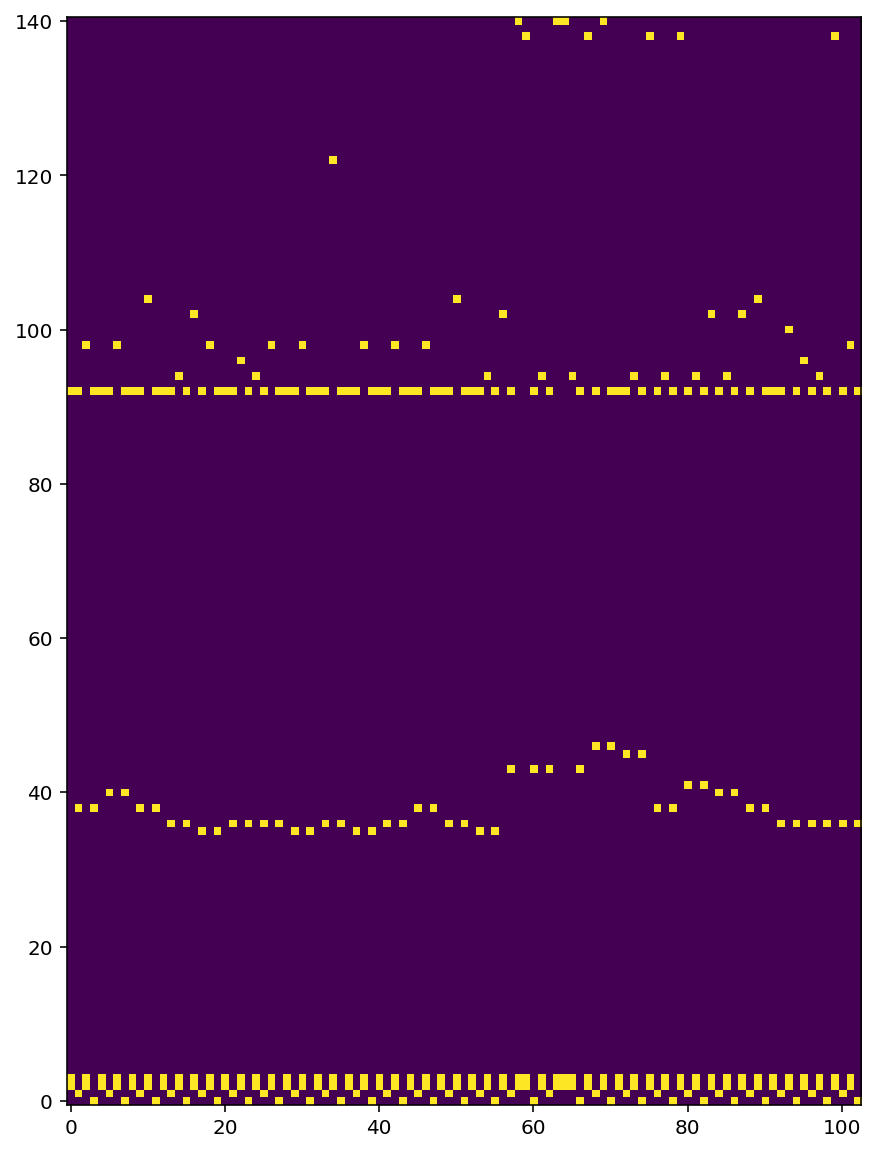

In [29]:
plot_matrix(data[2881].T)

In [30]:
data[2].shape

(436, 141)

## Training Examples

In [31]:
def get_example(matrix, start_row, input_timesteps=INPUT_TIMESTEPS, output_timesteps=OUTPUT_TIMESTEPS):
    """Returns a pair of input, output ndarrays. Input starts at start_row and has the given input length.
    Output starts at next timestep and has the given output length."""
    # Make sure there are enough time steps remaining.
    if len(matrix) < start_row + input_timesteps + output_timesteps:
        raise Exception('Not enough rows to get example.')
    input_ex = matrix[start_row : start_row + input_timesteps]
    output_ex = matrix[start_row + input_timesteps : start_row+input_timesteps+output_timesteps]
    return (input_ex, output_ex)

In [32]:
def get_examples_for_song(matrix, input_timesteps=INPUT_TIMESTEPS, output_timesteps=OUTPUT_TIMESTEPS, 
                          sliding_window_hop_length=SLIDING_WINDOW_TIMESTEPS):
    """Returns tuple of (array of input examples, array of output examples), generated via a sliding window on
    the input matrix. For example: output might be two ndarrays of shapes (277, 120, 141), (277, 40, 141).
    Dimensions are (examples, timesteps, features)
    """
    input_examples = []
    output_examples = []
    for i in range(len(matrix) - input_timesteps - output_timesteps + 1):
        x, y = get_example(matrix, i, input_timesteps, output_timesteps)
        input_examples.append(x)
        output_examples.append(y)
    if not input_examples:
        return None
    return np.stack(input_examples), np.stack(output_examples)

In [50]:
def output_examples_for_songs(output_filename_base, matrix_list, input_timesteps=INPUT_TIMESTEPS, output_timesteps=OUTPUT_TIMESTEPS, 
                           sliding_window_hop_length=SLIDING_WINDOW_TIMESTEPS):
    """Input is a list of matrices, each representing a song. Output is a tuple of 2 lists: input and output
    example matrices, one matrix per song."""
    input_examples = []
    output_examples = []
    file_index = 0
    for i, song in enumerate( matrix_list):
        result = get_examples_for_song(song, input_timesteps, output_timesteps, sliding_window_hop_length)
        if not result:
            continue
        x, y = result
        input_examples.append(x)
        output_examples.append(y)
        
        if i%100 == 0:
            print(i)
        if i%10 == 0:
            filename = '%s_%05d.pkl' % (output_filename_base, file_index)
            joblib.dump((input_examples, output_examples), filename)
            file_index += 1
            input_examples = []
            output_examples = []
    #return input_examples, output_examples

## Train/test split

In [48]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [35]:
#x_test, y_test = get_examples_for_songs(test_data)

In [36]:
#x_train, y_train = get_examples_for_songs(train_data)

In [46]:
#output_examples_for_songs('/data/mirex2018/test_pkl/test', test_data)

In [51]:
#output_examples_for_songs('/data/mirex2018/train_pkl/train', train_data, sliding_window_hop_length=4*10)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7100
7200
7300
7400
7500
7600
7700
7800
7900


In [39]:
'%05d' % 12

'00012'

In [52]:
del train_data

In [53]:
del test_data

NameError: name 'test_data' is not defined